In [27]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Add, Activation, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [28]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
x_train_flat = x_train.reshape(-1, 28*28)
x_test_flat = x_test.reshape(-1, 28*28)

In [29]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


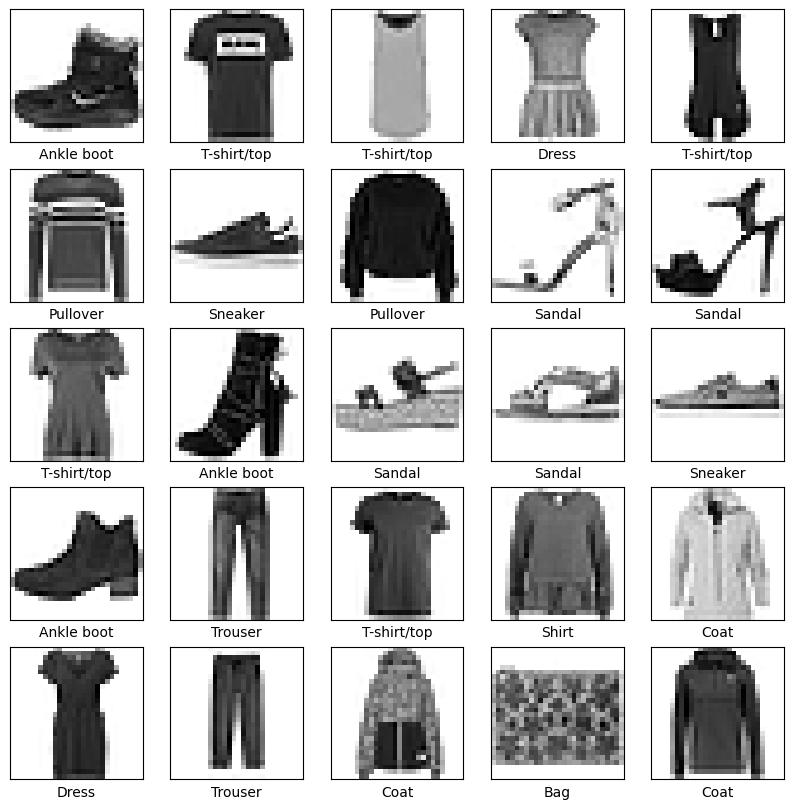

In [30]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([]); plt.yticks([]); plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[np.argmax(y_train[i])])
plt.show()

In [24]:
def create_resnet_dnn():
    initializer = tf.keras.initializers.HeNormal()
    inputs = Input(shape=(784,))

    x = Dense(512, kernel_initializer=initializer)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)

    x1 = Dense(512, kernel_initializer=initializer)(x)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)

    x2 = Dense(512, kernel_initializer=initializer)(x1)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)

    res1 = Add()([x, x2])
    res1 = Activation('relu')(res1)
    res1 = Dropout(0.25)(res1)

    x3 = Dense(256, kernel_initializer=initializer)(res1)
    x3 = BatchNormalization()(x3)
    x3 = Activation('relu')(x3)

    x4 = Dense(256, kernel_initializer=initializer)(x3)
    x4 = BatchNormalization()(x4)
    x4 = Activation('relu')(x4)

    res1_down = Dense(256, kernel_initializer=initializer)(res1)
    res1_down = BatchNormalization()(res1_down)
    res2 = Add()([res1_down, x4])
    res2 = Activation('relu')(res2)
    res2 = Dropout(0.25)(res2)

    x_final = Dense(128, kernel_initializer=initializer)(res2)
    x_final = BatchNormalization()(x_final)
    x_final = Activation('relu')(x_final)
    x_final = Dropout(0.2)(x_final)

    outputs = Dense(10, activation='softmax')(x_final)
    return Model(inputs, outputs)


In [33]:
model = create_resnet_dnn()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=4, verbose=1)

In [34]:
history = model.fit(x_train_flat, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=[early_stop, reduce_lr],
                    verbose=1)

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - accuracy: 0.6511 - loss: 1.0330 - val_accuracy: 0.8462 - val_loss: 0.4212 - learning_rate: 3.0000e-04
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.8341 - loss: 0.4695 - val_accuracy: 0.8624 - val_loss: 0.3798 - learning_rate: 3.0000e-04
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.8576 - loss: 0.3932 - val_accuracy: 0.8701 - val_loss: 0.3471 - learning_rate: 3.0000e-04
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.8715 - loss: 0.3621 - val_accuracy: 0.8787 - val_loss: 0.3332 - learning_rate: 3.0000e-04
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.8791 - loss: 0.3359 - val_accuracy: 0.8717 - val_loss: 0.3532 - learning_rate: 3.0000e-04
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8841 - loss: 0.3223 - val_accuracy: 0.8859 - val_loss: 0.3133 - learning_rate: 3.0000e-04
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/ste

In [35]:
test_loss, test_acc = model.evaluate(x_test_flat, y_test, verbose=0)
print(f"ResNet-style DNN Test Accuracy: {test_acc:.4f}")


ResNet-style DNN Test Accuracy: 0.9040


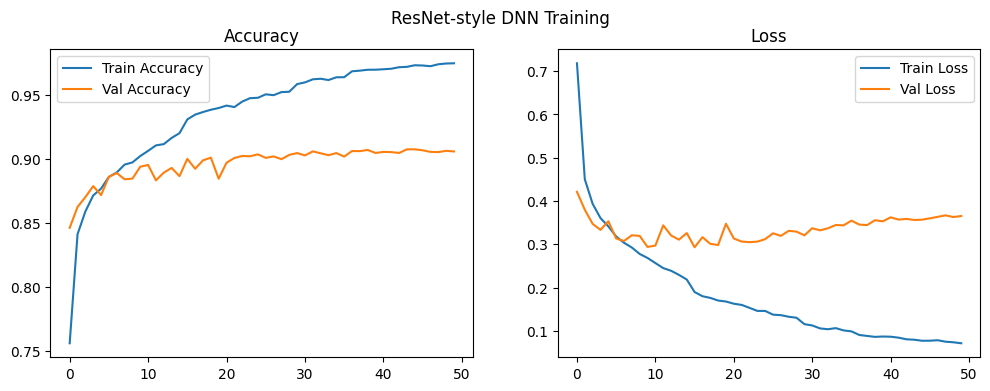

In [36]:
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.suptitle(title)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend(); plt.title("Accuracy")
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend(); plt.title("Loss")
    plt.show()

plot_history(history, "ResNet-style DNN Training")

# Predict & Show
def plot_predictions(model, x_test, y_test, num_images=5):
    predictions = model.predict(x_test)
    plt.figure(figsize=(15, 3*num_images))
    for i in range(num_images):
        plt.subplot(num_images, 1, i+1)
        plt.imshow(x_test[i].reshape(28, 28), cmap=plt.cm.binary)
        pred_label = np.argmax(predictions[i])
        true_label = np.argmax(y_test[i])
        color = 'green' if pred_label == true_label else 'red'
        plt.xlabel(f"Predicted: {class_names[pred_label]} (True: {class_names[true_label]})", color=color)
    plt.show()



ResNet-style DNN Predictions:
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


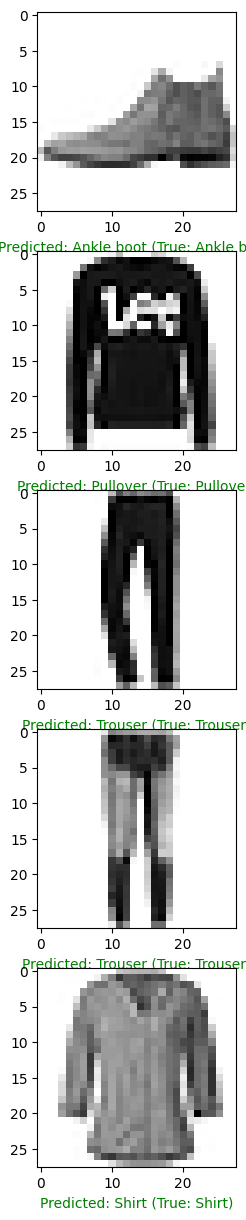

In [37]:
print("\nResNet-style DNN Predictions:")
plot_predictions(model, x_test_flat, y_test)